In [1]:
import logging

import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from ev_station_solver.constants import CONSTANTS
from ev_station_solver.loading import load_locations
import numpy as np
from tqdm import tqdm 
from ev_station_solver.solving.solver import Solver
from ev_station_solver.helper_functions import get_distance_matrix


In [2]:
# use given starting solutions
locations = load_locations("large").sample(50).values
n_clusters = int(len(locations) * CONSTANTS["mu_charging"] / (2 * CONSTANTS["station_ub"]))
service_level = 0.95

n_clusters = 3 if n_clusters < 3 else n_clusters

In [3]:
s = Solver(vehicle_locations=locations, loglevel=logging.INFO, service_level=service_level)

# compute number of initial locations
s.add_initial_locations(n_clusters, mode="k-means", seed=0)
s.add_samples(num=2)

2024-12-13 22:47:33,224 - ev_station_solver.solving.solver - INFO - add_initial_locations: Added 3 k-means locations. Total number of locations: 3.
2024-12-13 22:47:33,227 - ev_station_solver.solving.solver - INFO - add_samples: Added 2 samples.


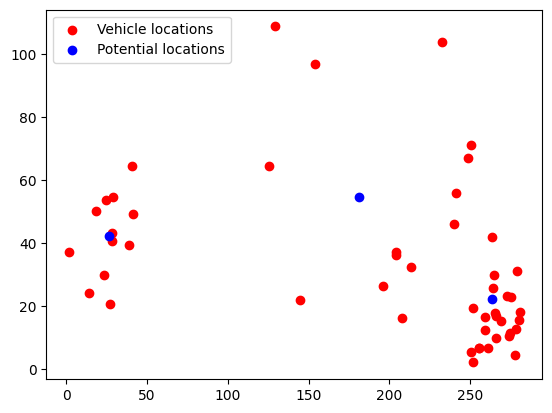

In [4]:
plt.scatter(s.vehicle_locations[:, 0], s.vehicle_locations[:, 1], c="red", label="Vehicle locations")
plt.scatter(s.coordinates_potential_cl[:, 0], s.coordinates_potential_cl[:, 1], c="blue", label="Potential locations")
plt.legend()
plt.show()

In [5]:
# create dataframe with all unique locations and the minimum range
locations = np.empty((0, 2))
ranges = np.empty(0)

for sample in s.S:
    # concatenate locations
    locations = np.concatenate((locations, sample.vehicle_locations), axis=0)
    # concatenate ranges
    ranges = np.concatenate((ranges, sample.ranges), axis=0)

In [6]:
# sort locations by range
sorted_indices = np.argsort(ranges)
locations = locations[sorted_indices]
ranges = ranges[sorted_indices]

In [7]:
# drop duplicates
unique_locations, unique_index = np.unique(locations, axis=0, return_index=True)
# update ranges
unique_ranges = ranges[unique_index]

In [8]:
# get distance matrix
distance_matrix = get_distance_matrix(unique_locations, symmetric=True)
total_ranges = unique_ranges[:, np.newaxis] + unique_ranges[np.newaxis, :]
reachibility_matrix = distance_matrix <= total_ranges
reachibility_matrix

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], shape=(36, 36))

In [9]:
from docplex.mp.model import Model

In [10]:
m = Model("ev_station")

In [11]:
# valid_intersections = set()

# for i in tqdm(range(len(unique_locations))):
#     # get all true indicies of the reachability matrix
#     reachability_indices = np.where(reachibility_matrix[i])[0]
#     # remove i 
#     reachibility_indices = np.delete(reachability_indices, reachability_indices== i)
#     # convert to list
#     reachability_indices = reachability_indices.tolist()
    
#     # compute all possible combinations for all rs
#     for k in range(len(reachability_indices)):
#         for combination in combinations(reachability_indices, k):
#             valid_intersections.add(combination)

In [12]:
import rustworkx as rw

In [13]:
G = rw.PyGraph().from_adjacency_matrix(reachibility_matrix.astype(float)) # create graph from adjacency matrix

In [ ]:
for k in tqdm(range(len(unique_locations))):
    rw.connected_subgraphs(G, k=k)

 14%|█▍        | 5/36 [00:00<00:01, 26.38it/s]